 ‫‪5‬‬‫‪-‬‬‫برای‬‫تصاویر‬ ‫حاصل‬ ‫از‬ ‫قسمت‬ ‫قبل‪،‬‬ ‫‪5‬‬ ‫ویژگی‬ ‫قابل‬ ‫توجه‬ ‫به‬ ‫طور‬ ‫دلخواه‬ ‫استخراج‬ ‫کنید‪.‬‬

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [16]:
files = ['Easy/car.jpg', 'Easy/church.jpg', 'Easy/flower.jpg', 'Easy/horse.jpg', 'Easy/pyrmid.jpg']
images = []

for file in files:
    images.append(cv2.imread('assignment/' + file))

In [17]:
rgb_images = []

for image in images:
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_images.append(rgb)

### Method #1: Grayscale Pixel Values as Features

In [4]:
gray_images = []
for file in files:
    gray = cv2.imread('assignment/' + file, cv2.IMREAD_GRAYSCALE)
    gray_images.append(gray)
    
# gray.shape # (321, 481)

In [5]:
features_of_images = []

for image in gray_images:
    features = np.reshape(image, (image.shape[0] * image.shape[1]))
    features_of_images.append(features)
    print(features)

[144 145 146 ...  48  50  55]
[ 31  30  29 ... 114 112  35]
[ 12  12  12 ... 143 145 153]
[ 59  58 140 ... 238 213 144]
[42 52 53 ... 80 84 88]


### Method #2: Mean Pixel Value of Channels

In [ ]:
# create a matrix of mean of all 3 channel of colored image
mean_matrix_images = []

for image in images:
    
    mean_matrix = np.zeros(image.shape[:2])
    
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            mean_matrix[row][col] = (int(image[row, col, 0]) + int(image[row, col, 1]) + int(image[row, col, 2])) / 3
            

    mean_matrix_images.append(mean_matrix)
    # print(mean_matrix.shape) # (321, 481)

print(mean_matrix)

[[44.33333333 54.33333333 55.         ... 79.         79.
  78.        ]
 [47.33333333 55.         55.         ... 80.         80.
  78.        ]
 [48.         55.33333333 53.33333333 ... 80.         80.
  79.33333333]
 ...
 [56.33333333 68.33333333 74.33333333 ... 80.66666667 76.66666667
  72.66666667]
 [78.         71.         71.         ... 69.66666667 80.66666667
  83.66666667]
 [69.         61.         54.66666667 ... 73.66666667 77.66666667
  81.66666667]]


### Method #3: Extracting Edge Features

### Method #4: Histogram

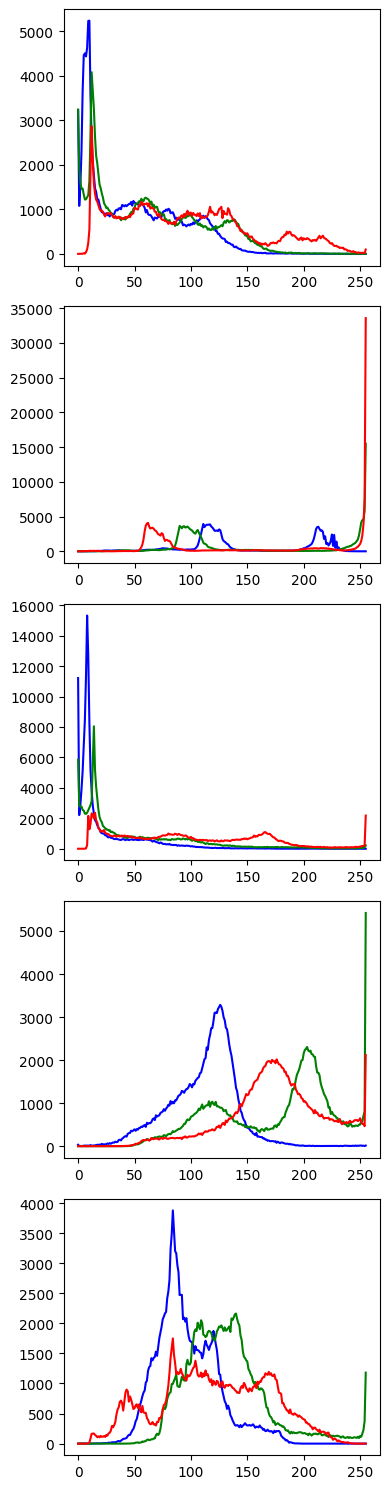

In [27]:
hists = []
colors = ('b', 'g', 'r')

figure, axis = plt.subplots(nrows=5, ncols=1, figsize=(4, 15))


for ii, image in enumerate(images):
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], channels=[i], mask=None, histSize=[256], ranges=[0, 256])
        axis[ii].plot(hist, color=color)



figure.tight_layout()

### Method 5: Chain Code

In [8]:
def draw(image, title = "Original Grayscale Image"):
    # Display original grayscale image
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

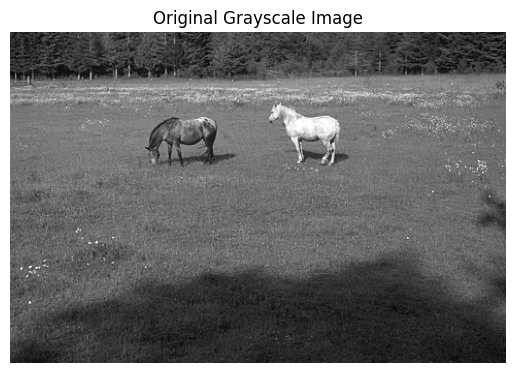

In [62]:
gray_image = cv2.imread('assignment/Medium/horse.jpg', cv2.IMREAD_GRAYSCALE)
draw(gray_image)

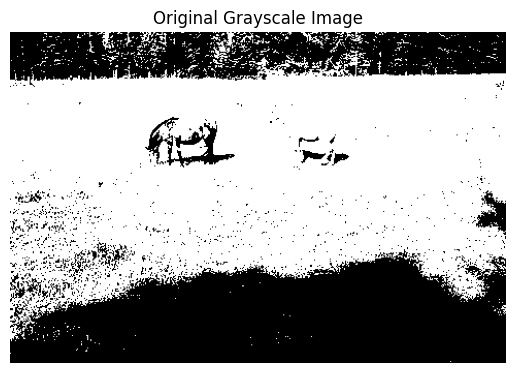

In [63]:
# Apply simple thresholding
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
draw(binary_image)

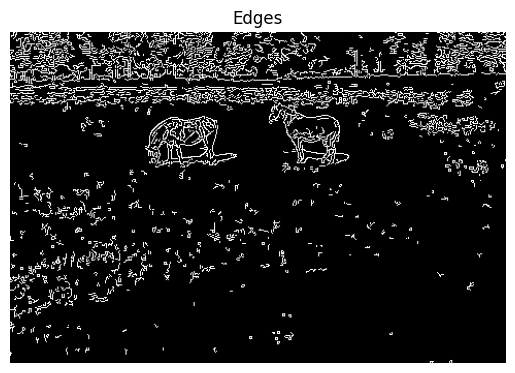

In [64]:
# Step 1: Convert the grayscale image to binary using Canny edge detection
edges = cv2.Canny(gray_image, 100, 200)
draw(edges, 'Edges')

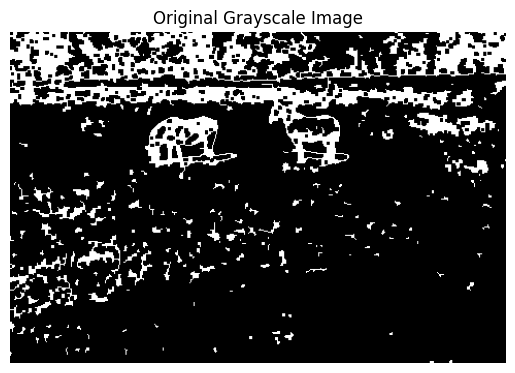

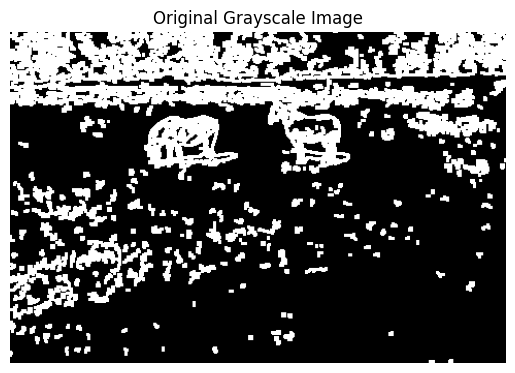

In [65]:
# Step 2: Apply morphological operations to close gaps and make edges thicker
kernel = np.ones((3, 3), np.uint8)
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
# erosion_edges = cv2.erode(closed_edges, kernel, iterations=1)
dilated_edges = cv2.dilate(closed_edges, kernel, iterations=1)
draw(closed_edges)
# draw(erosion_edges)
draw(dilated_edges)

In [66]:
# Function to extract the chain code and points from the binary image
def get_chain_code(binary_image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found.")
        return [], []

    # Select the largest contour, assuming it represents the main object
    contour = max(contours, key=cv2.contourArea)

    # Start from the first point in the contour
    chain_code = []
    points = [tuple(contour[0][0])]
    start_point = contour[0][0]

    # Mapping of directions according to Freeman's 8-directional chain code
    direction_map = {
        (0, 1): 0,  (1, 1): 1,  (1, 0): 2,  (1, -1): 3,
        (0, -1): 4, (-1, -1): 5, (-1, 0): 6, (-1, 1): 7
    }

    # Loop through the contour points to compute the chain code
    for i in range(1, len(contour)):
        point = contour[i][0]
        dx = point[0] - start_point[0]
        dy = point[1] - start_point[1]
        direction = direction_map.get((dx, dy), None)
        
        if direction is not None:
            chain_code.append(direction)
            start_point = point
            points.append((start_point[0], start_point[1]))

    return chain_code, points

In [67]:
# Step 3: Get chain code and points from the dilated edges
chain_code, points = get_chain_code(dilated_edges)


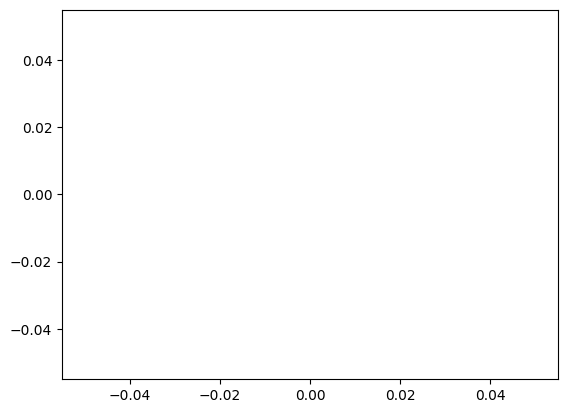

In [68]:
plt.plot(chain_code)

In [72]:
def get_chain_code(binary_image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming we are interested in the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Initialize the chain code
    chain_code = []
    
    # Define the 8 possible directions (clockwise)
    directions = [
        (0, 1),  # Right
        (1, 1),  # Down-Right
        (1, 0),  # Down
        (1, -1), # Down-Left
        (0, -1), # Left
        (-1, -1),# Up-Left
        (-1, 0), # Up
        (-1, 1)  # Up-Right
    ]

    # Starting point (first point of the contour)
    start_point = tuple(largest_contour[0][0])
    current_point = start_point

    # Loop through the contour points to generate the chain code
    for point in largest_contour[:, 0, :]:
        dx = point[0] - current_point[0]
        dy = point[1] - current_point[1]

        # Find the direction of movement
        for i, (dx_dir, dy_dir) in enumerate(directions):
            if (dx_dir == dx) and (dy_dir == dy):
                chain_code.append(i)
                break

        current_point = tuple(point)

    return chain_code

# Load a binary image (make sure it’s a binary image, e.g., thresholded)
image_path = 'assignment/Medium/horse.jpg'
binary_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(binary_image, 127, 255, cv2.THRESH_BINARY)

# Get the chain code
chain_code = get_chain_code(binary_image)
print("Chain Code:", chain_code)

Chain Code: [7, 7, 7, 6, 5, 7, 5, 6, 7, 5, 7, 5, 3, 4, 5, 6, 2, 1, 7, 5, 5, 7, 7, 7, 6, 5, 7, 5, 7, 7, 6, 5, 7, 5, 4, 0, 7, 5, 5, 5, 3, 6, 7, 5, 7, 6, 5, 7, 5, 4, 0, 7, 5, 0, 7, 6, 5, 6, 7, 5, 4, 6, 5, 5, 7, 5, 6, 7, 5, 7, 6, 7, 5, 7, 5, 7, 6, 7, 5, 4, 3, 4, 0, 7, 6, 7, 5, 1, 6, 5, 3, 4, 5, 6, 7, 5, 4, 0, 7, 5, 4, 6, 5, 1, 5, 3, 2, 4, 6, 0, 7, 6, 7, 5, 4, 0, 7, 6, 5, 5, 7, 0, 7, 6, 5, 3, 4, 7, 5, 6, 0, 7, 5, 3, 2, 4, 6, 0, 7, 5, 6, 0, 1, 3, 5, 1, 7, 6, 7, 5, 7, 5, 4, 3, 6, 5, 6, 0, 7, 6, 0, 7, 5, 4, 5, 7, 5, 7, 5, 4, 5, 7, 5, 7, 0, 2, 3, 3, 2, 1, 7, 5, 7, 0, 6, 4, 6, 5, 4, 5, 7, 5, 4, 3, 4, 6, 1, 7, 6, 7, 5, 7, 7, 1, 1, 3, 1, 0, 7, 7, 7, 0, 7, 7, 7, 5, 5, 7, 5, 0, 7, 6, 1, 7, 1, 2, 1, 2, 3, 1, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 1, 1, 4, 5, 3, 4, 3, 1, 3, 5, 3, 2, 1, 1, 7, 1, 0, 7, 5, 0, 1, 7, 1, 3, 1, 0, 7, 0, 4, 3, 7, 6, 5, 6, 7, 5, 4, 7, 5, 4, 5, 0, 7, 6, 5, 3, 5, 0, 3, 1, 1, 7, 0, 7, 5, 4, 6, 7, 6, 1, 0, 1, 0, 5, 3, 2, 1, 1, 3, 1, 0, 1, 7, 6, 7, 7, 5, 6, 1, 3, 7, 6, 7, 5, 6, 5, 4, 3, 